## Homer CTP Prediction
Problem: Using characteristics from a month-long trial period, predict whether a user converts to a paid customer (CTP = 1) or not (CTP = 0). Characteristics include usage metrics and consumer demographics.

In [376]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

dir(pd.options.display)
pd.options.display.max_columns = 50

In [2]:
homer = pd.read_csv('homer_clean.csv')
homer.drop(['single_user','multiple_user','distinct_weeks'], axis = 1, inplace = True)

### 1. Data Exploration
- Baseline conversion is 67.7% - will aim to construct a model with > 68% accuracy, which is the accuracy one would achieve by classifying CTP = 1 100% of the time

In [3]:
homer.describe()

,userid,total_events,completed_count,not_completed_count,ipad_event,iphone_event,ipod_event,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,first_week,second_week,third_week,distinct_days,avg_weekly_visit,avg_daily_hrs,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,distinct_titles,max_row,max_column,avg_row,avg_col,ctp
count,5.834000e+03,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5263.000000,5281.000000,5834.000000,5834.000000,5400.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5281.000000,5539.000000,5281.000000,5539.000000,5834.000000,3.466000e+03,3466.000000,3459.000000,3466.000000,5834.000000
mean,2.896520e+16,76.456462,50.795680,22.748543,33.600103,42.673294,0.183065,450.696561,460.993941,52.477374,23.979088,4.370926,0.984745,0.418581,0.344361,4.841104,25.489201,1.847103,13.122043,4.936921,7.557079,3.294073,2.553349,1.047340,4.024553,33.741001,-1.862770e+16,11.369013,3.195721,3.241777,0.677580
std,5.349841e+18,129.560791,79.699731,58.472953,103.347261,94.666740,6.184218,284.176825,280.201537,77.953686,79.335395,1.742342,0.122578,0.493369,0.475200,4.759494,29.341279,2.920150,11.508560,5.473731,3.996430,1.188351,1.352938,0.258992,1.921381,39.809618,4.141409e+17,13.144738,2.603580,3.185256,0.467443
min,-9.219518e+18,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-9.223372e+18,0.000000,0.000000,0.000000,0.000000
25%,-4.615946e+18,13.000000,8.000000,3.000000,0.000000,0.000000,0.000000,251.000000,251.000000,8.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,8.000000,0.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,2.000000,9.000000,2.000000e+00,3.000000,1.000000,1.000000,0.000000
50%,-3.989598e+16,36.000000,25.000000,8.000000,0.000000,10.000000,0.000000,351.000000,361.000000,26.000000,2.000000,5.000000,1.000000,0.000000,0.000000,3.000000,17.000000,0.000000,12.000000,3.000000,8.000000,3.000000,2.000000,1.000000,4.000000,20.000000,5.000000e+00,7.000000,2.000000,2.000000,1.000000
75%,4.680110e+18,91.000000,62.000000,22.000000,21.000000,46.000000,0.000000,601.000000,601.000000,66.000000,16.000000,6.000000,1.000000,1.000000,1.000000,6.000000,32.000000,3.000000,25.000000,8.000000,11.000000,4.000000,3.000000,1.000000,5.000000,43.000000,1.300000e+01,18.000000,4.000000,4.000000,1.000000
max,9.221033e+18,3416.000000,1948.000000,1578.000000,3416.000000,2615.000000,425.000000,1563.000000,1563.000000,1258.000000,2540.000000,9.000000,1.000000,1.000000,1.000000,32.000000,683.000000,23.000000,31.000000,30.000000,14.000000,5.000000,11.000000,4.000000,14.000000,398.000000,2.800000e+01,105.000000,27.000000,40.000000,1.000000


In [4]:
homer.head()

,userid,path_type,multi_user_label,total_events,completed_count,completed_cat,not_completed_count,event_count_cat,device_cat,ipad_event,iphone_event,ipod_event,max_stage_complete,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,max_stage,first_week,second_week,third_week,distinct_days,avg_weekly_visit,avg_daily_hrs,weekly_visit_cat,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,pop_event_day,pop_title,pop_category,distinct_titles,title_count_cat,max_row,max_column,avg_row,avg_col,ctp
0,-9.219518e+18,"alc, pathways",Single-user,36,25,med,8,medium,iPhone,0,36,0,A,121.0,211.0,9,27,NaN,A,1,1,1,6,9,0,medium,21,16,14,1.0,1.0,1.0,1.0,Saturday,Letter Hunt,GAM,24,high,1.0,25.0,1.0,9.0,1
1,-9.218149e+18,pathways,Single-user,5,4,low,0,low,iPhone,0,5,0,A,121.0,211.0,5,0,1.0,A,1,0,1,2,3,0,low,20,4,1,1.0,1.0,1.0,1.0,Sunday,Letter Hunt,NaN,2,low,NaN,NaN,NaN,NaN,0
2,-9.217416e+18,"alc, pathways",Single-user,59,36,med,21,high,iPhone,0,59,0,C,511.0,521.0,40,19,4.0,C,1,0,0,2,30,0,high,5,3,8,3.0,3.0,1.0,6.0,Friday,"Make the Letters: A,a",NaN,39,high,20.0,16.0,3.0,4.0,0
3,-9.217257e+18,"alc, pathways",Single-user,126,111,very_high,14,very high,iPad,126,0,0,C,351.0,351.0,27,99,4.0,C,1,1,1,10,42,3,very high,16,10,5,3.0,2.0,1.0,6.0,Thursday,Swimmy,RAS,87,very high,21.0,15.0,4.0,4.0,1
4,-9.212743e+18,"alc, pathways",Multiple-user,144,105,very_high,35,very high,iPad,144,0,0,B,961.0,961.0,64,80,3.0,B,1,1,1,14,36,3,very high,22,7,9,2.0,5.0,1.0,4.0,Tuesday,The Airport,NaN,87,very high,28.0,16.0,2.0,3.0,1


In [5]:
#benchmarks:
baseline = homer['ctp'].value_counts()[1]/homer['ctp'].value_counts().sum()
print(f'baseline conversion is {baseline}')
print('distinct users is {}'.format(homer['userid'].nunique()))

baseline conversion is 0.6775797051765513
distinct users is 5834


In [744]:
#calculate conversion rates for CTP for every categorical variable
#visualize results to investigate relationships
def conversion_calc(df, column, plot = True):
    if plot:
        plt.rcParams['figure.figsize'] = (7,45)
        figure, axes = plt.subplots(len(categorical_columns))
    for i in range(0, len(categorical_columns)):
        category = column[i]
        grouped = df.groupby([category,'ctp'])[['ctp']].count().rename(columns={'ctp':'count'}).reset_index()
        grouped['total']=[grouped[grouped[category]==element]['count'].sum() for element in grouped[category]]
        grouped['conversion'] = grouped['count']/grouped['total']
        if plot:
            mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
            sns.barplot(grouped[category], grouped['conversion'], hue = grouped['ctp'], ax = axes[i], palette = 'mako_r')
            axes[i].title.set_text(column[i])
            axes[i].set_xlabel('')
            figure.subplots_adjust(hspace = 0.37)
        else:
            return grouped

#visualize distribution of continuous variables, separated by CTP
def plot_continuous(df, continuous_columns):
    plt.rcParams['figure.figsize'] = [7, 40]
    figure, axes = plt.subplots(len(continuous_columns))
    for i in range (0, len(continuous_columns)):
        ctp_1 = df.loc[df['ctp']==1]
        ctp_0 = df.loc[df['ctp']==0]
        sns.distplot(ctp_1[continuous_columns[i]], hist = False, kde_kws={'shade':True}, ax = axes[i], color = 'green')
        sns.distplot(ctp_0[continuous_columns[i]], hist = False, kde_kws={'shade':True}, ax = axes[i], color = 'orange')
        axes[i].title.set_text(continuous_columns[i])
        axes[i].set_xlabel('')
        figure.subplots_adjust(hspace = 0.37)

#### Categories with correlation to CTP:
- path_type (alc, pathways)
- completed cat (high, very high)
- event_count_cat (high, very high)
- device cat (ipad)
- max_stage (C, D, E)
- weekly_visit_cat (high, very high)
- max_days_into_trial (> 20)
- distinct_weeks (4)
- distinct days (> 15)
- average_age_int (3-7)
- avg_level
- avg_cluster

#### Categories with little correlation to CTP:
- multi_user_label
- pop_event_day

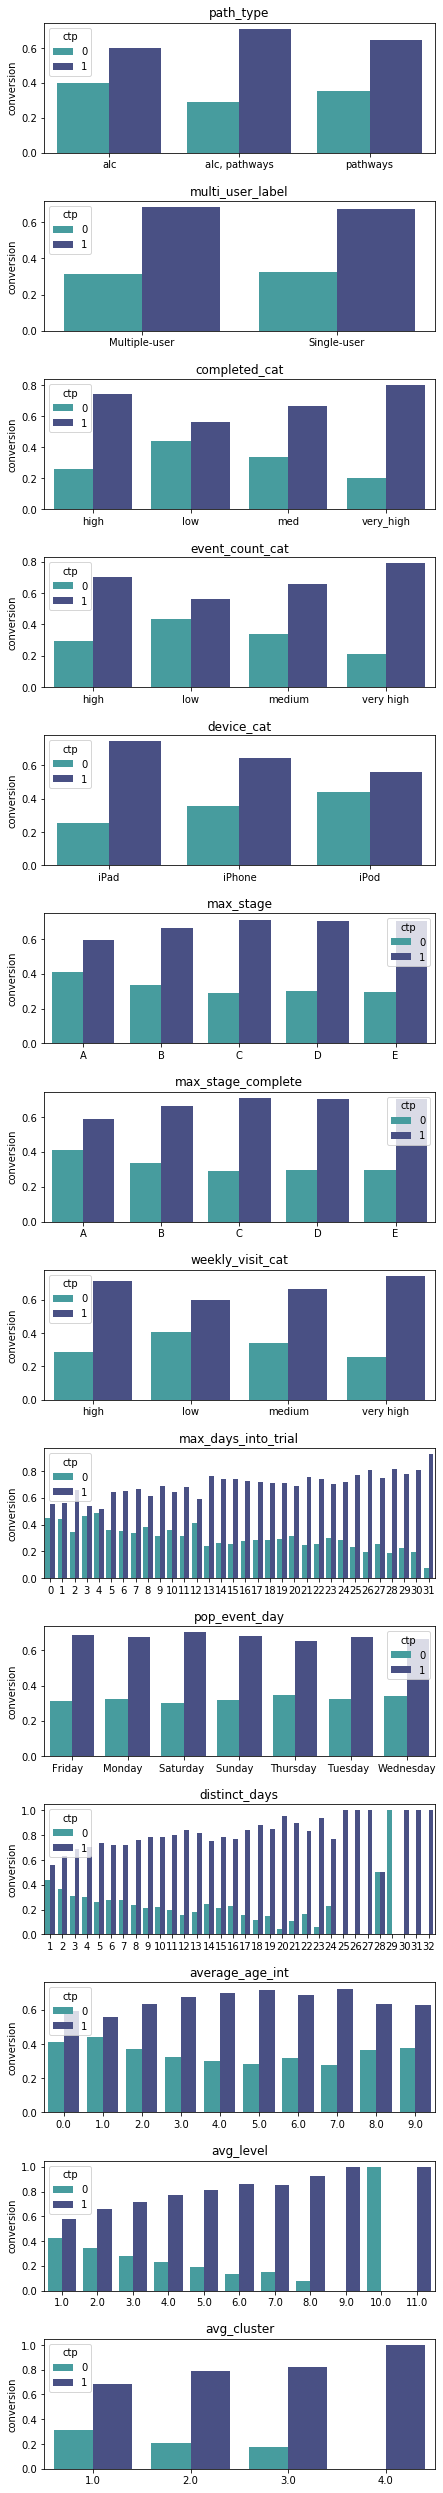

In [745]:
categorical_columns = ['path_type','multi_user_label','completed_cat','event_count_cat',
                      'device_cat','max_stage','max_stage_complete','weekly_visit_cat','max_days_into_trial','pop_event_day',
                      'distinct_days', 'average_age_int', 'avg_level','avg_cluster']

conversion_calc(homer, categorical_columns, plot = True)

#### Distributions to look at:
- total_events
- not_completed_count
- ipad_event
- iphone_event
- ipod_event
- avg_weekly_visit
- avg_daily_hrs
- max_row
- max_column
- avg_row
- avg_col
- max_days_into_trial

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


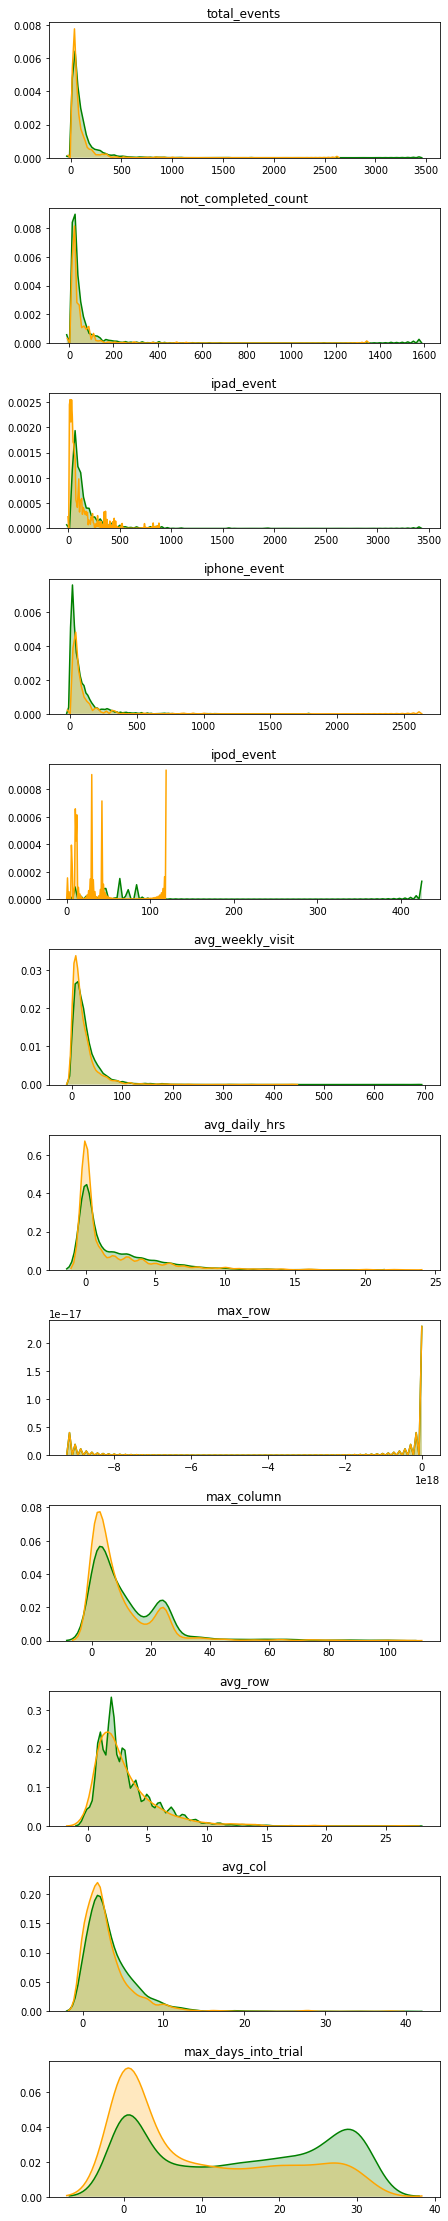

In [8]:
continuous_columns = ['total_events','not_completed_count','ipad_event','iphone_event','ipod_event','avg_weekly_visit',
                     'avg_daily_hrs','max_row','max_column','avg_row','avg_col','max_days_into_trial']

plot_continuous(homer, continuous_columns)

### 2. Data Preprocessing
- adjust for nulls
- make dummy variables: multi_user_label, completed_cat, event_count_cat, device_cat, max_stage_complete,
- max_stage, pop_event_day, pop_title (titles with conversion > baseline only)

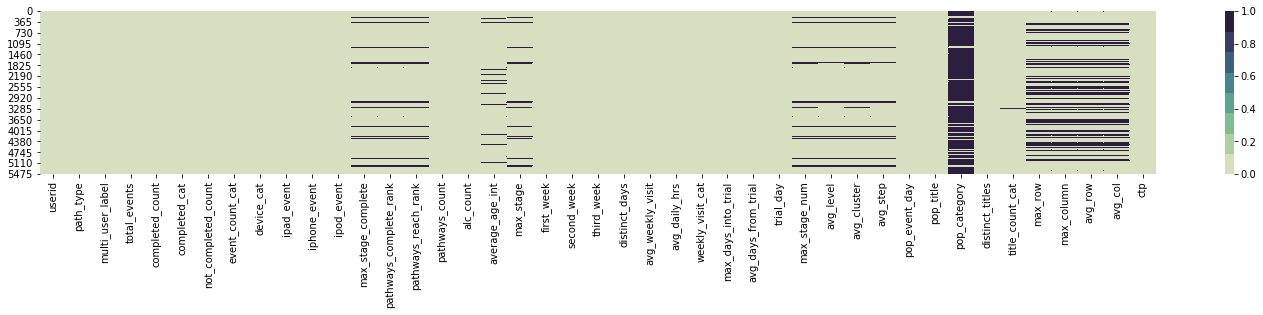

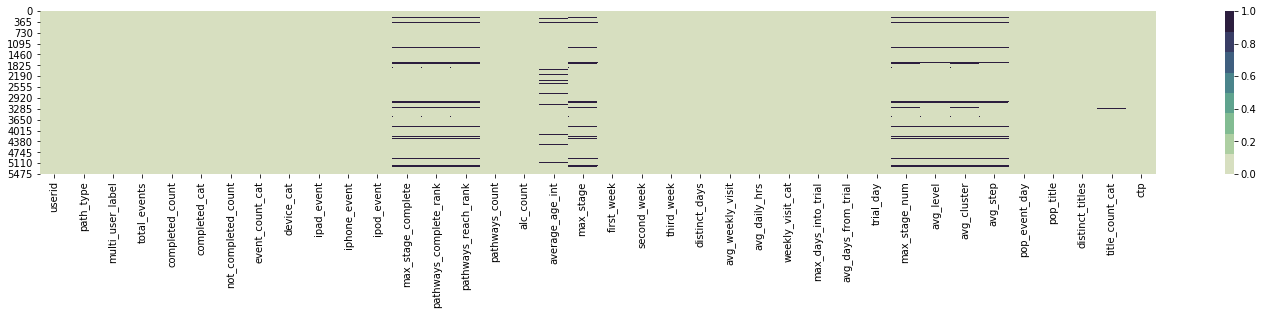

In [9]:
#display missing values before and after removing unecessary columns
plt.rcParams['figure.figsize'] = (25,3)
mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
sns.heatmap(homer.isnull(), cmap = mypalette)
plt.show()

#max_row, max_col, avg_row, avg_col don't seem to have strong correlation with CTP - delete
#pop_category is mostly missing - delete
homer_clean = homer.drop(['max_row','max_column','avg_row','avg_col','pop_category'],inplace = False, axis = 1)

sns.heatmap(homer_clean.isnull(), cmap = mypalette)
plt.show()

#for now, drop any rows with null values - revisit later
#can use knn imputation methods, since using average might not make sense
homer_nonull = homer_clean.dropna().reset_index(drop = True)

In [10]:
#look at conversion rates for top 20 titles
#75% of rows in dataset belong to top 20 titles
alltitles = pd.Series(homer_nonull['pop_title'].unique())
top20titles = homer_nonull['pop_title'].value_counts().nlargest(n=20).index
pop_titles = homer_nonull[homer_nonull['pop_title'].isin(top20titles)]
percent = pop_titles['pop_title'].value_counts().sum()/homer_nonull.shape[0]
print(f'percent of total records with top 20 title: {percent}')

#create indicator columns for titles where the conversion is better than the baseline
title_conversions = conversion_calc(pop_titles, ['pop_title'], False)
best_titles = title_conversions[title_conversions['conversion'] > baseline]['pop_title'].to_list()
print('top 20 most popular titles with high conversion are:')
for element in best_titles:
    print('  -'+element)

percent of total records with top 20 title: 0.7576819962878945
top 20 most popular titles with high conversion are:
  -Angelina: Our Favorite Time of Year is Spring
  -Let's Draw
  -Memory Game: Friends
  -Power Practice
  -Same or Different
  -Sounds Abound
  -Speed Read
  -Teamwork!
  -What's That Sound?


In [11]:
homer_nonull.head()

dummy_columns = ['path_type','multi_user_label','device_cat','pop_event_day','pop_title']
repeat_categories = ['weekly_visit_cat','title_count_cat','event_count_cat','completed_cat',
                    'max_stage_complete','max_stage']
all_columns = dummy_columns + repeat_categories

#add column name to low/med/high columns so dummy names for these columns are distinct
for column in repeat_categories:
    homer_nonull[column] = column + '_' + homer_nonull[column]

#get dummies only for top titles
non_top_titles = list(alltitles[~alltitles.isin(best_titles)])
homer_nonull['pop_title'] = homer_nonull['pop_title'].replace(to_replace = list(non_top_titles),value = None)
homer_nonull['pop_title'] = homer_nonull['pop_title'].replace(non_top_titles,None)
homer_nonull_dummies = pd.get_dummies(homer_nonull[all_columns],prefix = 'cat')
homer_nonull_noncat = homer_nonull[[column for column in homer_nonull.columns if column not in all_columns]]
final = pd.merge(homer_nonull_dummies, homer_nonull_noncat, left_index = True, right_index = True, how = 'outer')

In [12]:
#confirm all types are numeric and no nulls
print(final.dtypes.unique())
print(final.isnull().sum().unique())
print(final.columns)

[dtype('uint8') dtype('float64') dtype('int64')]
[0]
Index(['cat_alc, pathways', 'cat_pathways', 'cat_Multiple-user',
       'cat_Single-user', 'cat_iPad', 'cat_iPhone', 'cat_iPod',
       'cat_Friday   ', 'cat_Monday   ', 'cat_Saturday ', 'cat_Sunday   ',
       'cat_Thursday ', 'cat_Tuesday  ', 'cat_Wednesday',
       'cat_Angelina: Our Favorite Time of Year is Spring', 'cat_Let's Draw',
       'cat_Letter Hunt', 'cat_Memory Game: Friends', 'cat_Power Practice',
       'cat_Same or Different', 'cat_Sounds Abound', 'cat_Speed Read',
       'cat_Teamwork!', 'cat_What's That Sound?', 'cat_weekly_visit_cat_high',
       'cat_weekly_visit_cat_low', 'cat_weekly_visit_cat_medium',
       'cat_weekly_visit_cat_very high', 'cat_title_count_cat_high',
       'cat_title_count_cat_low', 'cat_title_count_cat_med',
       'cat_title_count_cat_very high', 'cat_event_count_cat_high',
       'cat_event_count_cat_low', 'cat_event_count_cat_medium',
       'cat_event_count_cat_very high', 'cat_complete

In [346]:
#X = final[[column for column in final.columns if column != 'ctp']]
X=final[['pathways_count', 'alc_count', 'average_age_int', 'first_week',
       'second_week', 'third_week', 'distinct_days', 'avg_weekly_visit',
       'avg_daily_hrs', 'max_days_into_trial', 'avg_days_from_trial',
       'trial_day', 'max_stage_num', 'avg_level', 'avg_cluster', 'avg_step',
       'distinct_titles']]
y = final['ctp']

## Compare models: KNN, Logistic Regression, Decision Trees
- train_test_split data
- feature scaling 
- hypertune parameters for each model
- record each model's highest CV score
- choose best model

In [680]:
class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test, self.X_train_scaled, self.X_test_scaled = self.split_scale_data()
        
        
    def split_scale_data(self):
        X=self.X
        y=self.y
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return (X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)
        
        
    def rs_knn(self, scaled = True, df = False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        knn_results = []
        knn = KNeighborsClassifier()
        params_knn = [{'weights':['uniform','distance'],
                  'n_neighbors':range(1,15)}]
        rs_knn = RandomizedSearchCV(knn, param_distributions = params_knn, cv = 5)
        if scaled:
            rs_knn.fit(X_train_scaled, y_train)
            knn_results=['KNN',rs_knn.best_params_, rs_knn.best_score_]
            if df:
                knn_df = pd.DataFrame(rs_knn.cv_results_).iloc[:,4:]
            else:
                knn_df = None
        else:
            rs_knn.fit(X_train, y_train)
            knn_results=['KNN',rs_knn.best_params_, rs_knn.best_score_]
            if df:
                knn_df = pd.DataFrame(rs_knn.cv_results_).iloc[:,4:]
            else:
                knn_df = None
        return knn_results, knn_df

    
    def rs_logistic(self, scaled = True, df = False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        log_results = []
        log = LogisticRegression()
        params_log = [{'penalty':['l2'],
                  'C':[10**n for n in range (-10,10)],
                      'max_iter':[100, 200, 300,400],
                      'solver':['lbfgs', 'liblinear']},
                     {'penalty':['l1'],
                  'C':[10**n for n in range (-10,10)],
                      'max_iter':[100, 200, 300,400],
                      'solver':['liblinear']}]
 
        rs_log = RandomizedSearchCV(log, param_distributions = params_log)
        if scaled:
            rs_log.fit(X_train_scaled, y_train)
            log_results=['Logistic',rs_log.best_params_, rs_log.best_score_]
            if df:
                log_df = pd.DataFrame(rs_log.cv_results_).iloc[:,4:]
            else:
                log_df = None
        else:
            rs_log.fit(X_train, y_train)
            log_results=['Logistic',rs_log.best_params_, rs_log.best_score_]
            if df:
                log_df = pd.DataFrame(rs_log.cv_results_).iloc[:,4:]
            else:
                log_df = None
        return log_results, log_df
    
    
    def rs_randomforest(self, df = False):
        X_train = self.X_train
        X_test = self.X_test
        X_train_scaled = self.X_train_scaled
        X_test_scaled = self.X_test_scaled
        y_train = self.y_train
        y_test = self.y_test
    
        rf_results = []
        rf = RandomForestClassifier()
        params_rf = [{'n_estimators':[100,200,300],
                       'criterion':['gini', 'entropy'],
                       'max_depth':[3,5,8,10,None],
                       'bootstrap':[True, False]}]
        rs_randomforest = RandomizedSearchCV(rf, param_distributions = params_rf)
        rs_randomforest.fit(X_train, y_train)
        rf_results = ['Random Forest',rs_randomforest.best_params_, rs_randomforest.best_score_]
        if df:
            rf_df = pd.DataFrame(rs_randomforest.cv_results_).iloc[:,4:]
        else:
            rf_df = None
        return rf_results, rf_df

In [681]:
mymodel = Model(X,y)
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = mymodel.split_scale_data()
knn_results, knn_df = mymodel.rs_knn(scaled = True, df = True)
log_results, log_df = mymodel.rs_logistic(scaled = True, df = True)
rf_results, rf_df = mymodel.rs_randomforest(df = True)

In [742]:
def model_comparison(knn_results, log_results, rf_results):
    figure, subaxes = plt.subplots(1,3, figsize = (9,3))
    results = [knn_results, log_results, rf_results]
    models = [KNeighborsClassifier, LogisticRegression, RandomForestClassifier]
    axes = range(0,len(models))
    scores = {}
    for axis, result, model in zip(axes,results,models):
        model_fit = model().set_params(**result[1]).fit(X_train_scaled, y_train)
        score = model_fit.score(X_test_scaled, y_test)
        y_predicted = model_fit.predict(X_test_scaled)
        f1 = f1_score(y_test, y_predicted)
        plot_confusion_matrix(model_fit, X_test_scaled, y_test, ax=subaxes[axis], cmap = 'mako_r', normalize = 'all')
        subaxes[axis].set_title(result[0])
        scores[result[0]]=(f1, score)
        plt.tight_layout()
    plt.show()
    for k, v in scores.items():
        print(f'{k.upper()}: F1_score is {v[0]:.4}, Test score is {v[1]:.4}, ')
    print(f'Best model is {max(scores, key=lambda x: scores[x][1])} model.')
    return scores

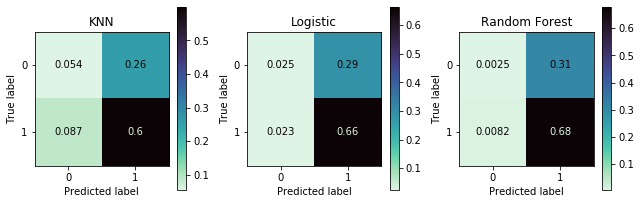

KNN: F1_score is 0.7755, Test score is 0.6529, 
LOGISTIC: F1_score is 0.8099, Test score is 0.6884, 
RANDOM FOREST: F1_score is 0.8096, Test score is 0.681, 
Best model is Logistic model.


In [743]:
scores = model_comparison(knn_results, log_results, rf_results)